<a href="https://colab.research.google.com/github/Finto30/Finto30/blob/main/KlasifikasiGulaMerah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# KLASIFIKASI JENIS GULA MERAH BERDASARKAN WARNA HSV MENGGUNAKAN RANDOM FOREST PARALEL


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import drive
from sklearn.model_selection import cross_val_score
from google.colab import files

KONFIGURASI DATASET DAN PARAMETER

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_DIR = '/content/drive/MyDrive/dataset/dataset_new'
IMG_SIZE = (224, 224)
TEST_SIZE = 0.2
RANDOM_STATE = 77
N_ESTIMATORS = 350
MODEL_OUTPUT = "model_rf_hsv.joblib"

FUNGSI UNTUK MEMBACA DAN PRA-PROSES CITRA


In [ ]:
def read_and_preprocess(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.GaussianBlur(img, (3,3), 0)
    return img

MASKING HSV

In [ ]:
def hsv_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Range warna gula merah
    lower = np.array([5, 40, 40])
    upper = np.array([30, 255, 255])

    mask = cv2.inRange(hsv, lower, upper)
    masked = cv2.bitwise_and(img, img, mask=mask)
    return mask, masked


CANNY, THRESHOLDING, KONTUR

In [ ]:
def extract_edge_features(img_gray):
    # Thresholding Otsu
    _, th = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Canny Edge Detection
    edges = cv2.Canny(img_gray, 80, 160)

    # Contour Detection
    conts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(conts) > 0:
        c = max(conts, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perimeter = cv2.arcLength(c, True)
    else:
        c = None
        area = 0
        perimeter = 0

    return edges, th, c, area, perimeter

EKSTRAKSI FITUR LENGKAP (HSV + MASKING + TEPI + KONTUR)


 Menampilkan visualisasi 



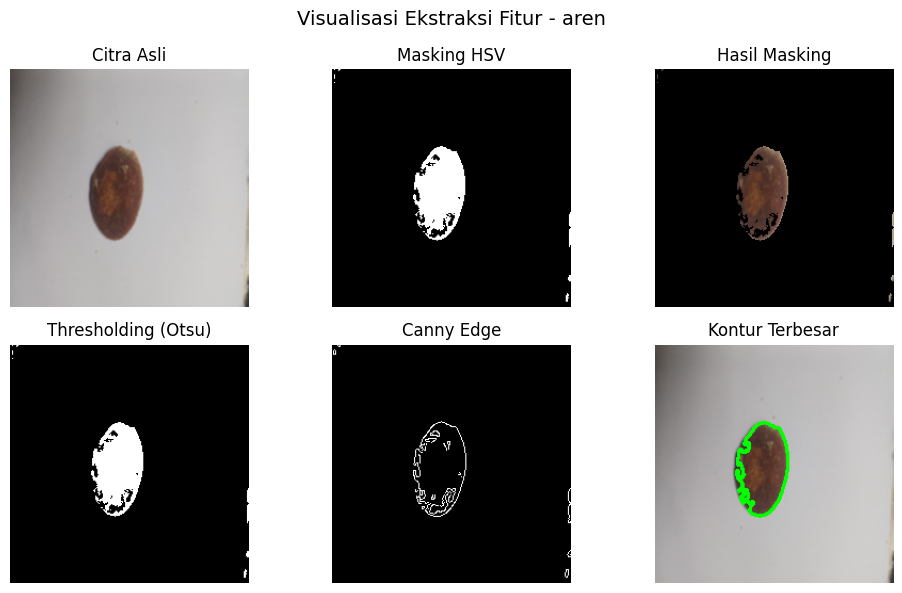

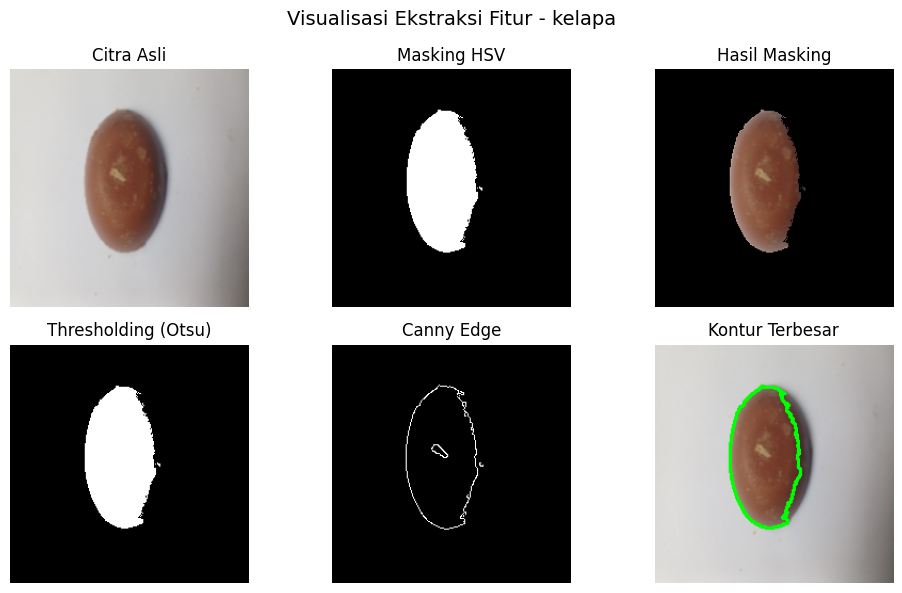

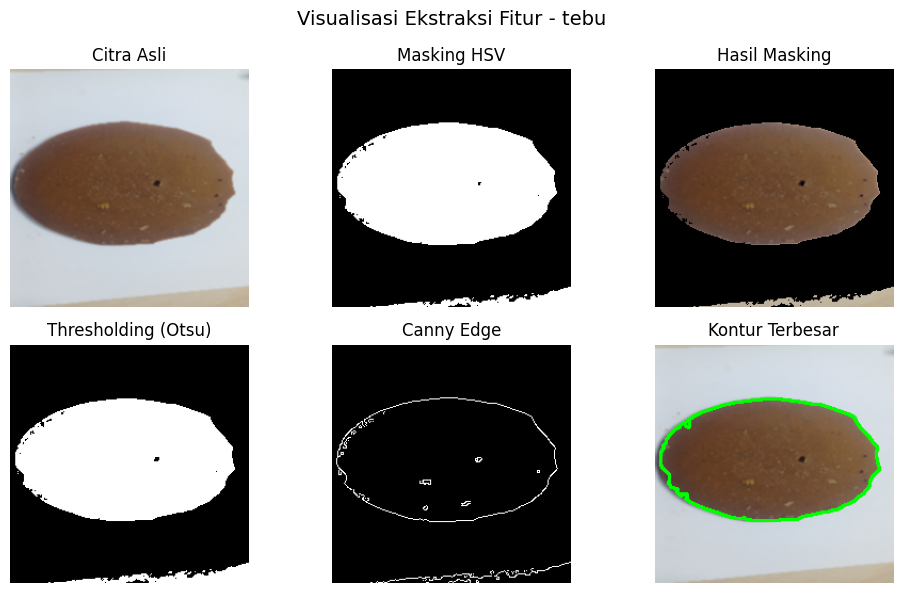

In [ ]:
def extract_all_features(img):
    # HSV Feature
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    h, s, v = hsv[...,0].ravel(), hsv[...,1].ravel(), hsv[...,2].ravel()

    hsv_features = {
        "mean_H": np.mean(h), "std_H": np.std(h), "skew_H": skew(h),
        "mean_S": np.mean(s), "std_S": np.std(s), "skew_S": skew(s),
        "mean_V": np.mean(v), "std_V": np.std(v), "skew_V": skew(v),
    }

    # Masking HSV
    mask, masked_img = hsv_mask(img)
    gray = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)

    # Edge + Threshold + Contour
    edges, th, contour, area, perimeter = extract_edge_features(gray)

    edge_features = {
        "edge_mean": np.mean(edges),
        "edge_std": np.std(edges),
        "contour_area": area,
        "contour_perimeter": perimeter
    }

    # Combine features
    hsv_features.update(edge_features)

    return hsv_features

def visualize():
    print("\n Menampilkan visualisasi \n")
    for cls in classes:
        folder = os.path.join(DATASET_DIR, cls)
        images = glob(os.path.join(folder, "*.jpg"))

        if len(images) == 0:
            print(f"Tidak ada gambar pada kelas {cls}")
            continue

        sample_path = images[0]
        img = read_and_preprocess(sample_path)

        # Masking HSV
        mask, masked_img = hsv_mask(img)

        # Edge & Contour
        gray = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
        edges, th, contour, area, perimeter = extract_edge_features(gray)

        img_contour = img.copy()
        if contour is not None:
            cv2.drawContours(img_contour, [contour], -1, (0, 255, 0), 2)

        # --- PLOT ---
        plt.figure(figsize=(10,6))

        plt.suptitle(f"Visualisasi Ekstraksi Fitur - {cls}", fontsize=14)

        plt.subplot(2,3,1)
        plt.imshow(img)
        plt.title("Citra Asli")
        plt.axis("off")

        plt.subplot(2,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Masking HSV")
        plt.axis("off")

        plt.subplot(2,3,3)
        plt.imshow(masked_img)
        plt.title("Hasil Masking")
        plt.axis("off")

        plt.subplot(2,3,4)
        plt.imshow(th, cmap="gray")
        plt.title("Thresholding (Otsu)")
        plt.axis("off")

        plt.subplot(2,3,5)
        plt.imshow(edges, cmap="gray")
        plt.title("Canny Edge")
        plt.axis("off")

        plt.subplot(2,3,6)
        plt.imshow(img_contour)
        plt.title("Kontur Terbesar")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Panggil fungsi visualisasi
visualize()

BANGUN DATASET FITUR

In [ ]:
rows = []
classes = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])

for cls in classes:
    folder = os.path.join(DATASET_DIR, cls)
    images = glob(os.path.join(folder, "*.jpg"))
    for path in tqdm(images, desc=f"Ekstraksi fitur: {cls}"):
        img = read_and_preprocess(path)
        feats = extract_all_features(img)
        feats["label"] = cls
        rows.append(feats)

df = pd.DataFrame(rows)

Ekstraksi fitur: tebu: 100%|██████████| 111/111 [00:13<00:00,  8.36it/s]


In [ ]:
df

,mean_H,std_H,skew_H,mean_S,std_S,skew_S,mean_V,std_V,skew_V,edge_mean,edge_std,contour_area,contour_perimeter,label
0,76.351105,76.493599,0.271130,11.871154,28.061724,3.611364,175.737244,31.717667,-1.640986,3.735352,30.635956,2983.0,336.676187,aren
1,84.420341,76.873962,0.001734,10.597716,27.920004,3.707901,174.712708,31.942432,-1.573626,2.749422,26.335210,2981.5,264.350285,aren
2,49.668110,71.619926,1.080541,14.252890,27.663694,3.603602,176.473816,32.136806,-1.522750,3.405014,29.269174,2819.0,255.622364,aren
3,30.176180,54.874149,2.090130,15.388114,27.829935,3.349805,175.535690,31.917370,-1.534525,3.709941,30.533118,2772.5,306.492421,aren
4,24.584263,46.700710,2.657796,17.682697,28.125431,3.106489,175.520462,32.767673,-1.454224,4.101264,32.078059,2714.5,282.007140,aren
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,80.405594,45.639153,-0.728079,36.413742,49.492409,1.533906,172.477798,44.266479,-0.989980,3.801419,30.901635,7153.0,472.617311,tebu
328,85.000916,41.994057,-1.095795,35.545139,47.766750,1.534750,174.403519,45.071056,-1.030243,3.034020,27.649049,10111.5,523.771640,tebu
329,60.679508,60.465809,0.569216,31.617107,52.283035,1.460270,173.908142,44.005848,-0.999254,3.445671,29.441018,10570.5,498.315797,tebu
330,83.826408,43.303768,-0.975620,33.746532,46.619804,1.493636,166.284760,45.769939,-1.028587,3.318618,28.900424,9681.0,528.558436,tebu


PEMBAGIAN DATA & PELATIHAN MODEL RANDOM FOREST PARALEL

In [ ]:
X = df.drop(columns=['label']).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"
)

print("\nMulai melatih model Random Forest")
model.fit(X_train, y_train)
joblib.dump(model, MODEL_OUTPUT)
print(f"Model disimpan sebagai {MODEL_OUTPUT}")


Mulai melatih model Random Forest
Model disimpan sebagai model_rf_hsv.joblib


PREDIKSI & EVALUASI MODEL

In [ ]:
y_pred = model.predict(X_test)

print("\nHASIL EVALUASI:")
acc_score = round(accuracy_score(y_pred, y_test), 3)
print(f'Accuracy: {acc_score*100:.2f}%')
scores = cross_val_score(model, X, y, cv=5)
print(f"Rata-rata akurasi 5-Fold: {scores.mean()*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


HASIL EVALUASI:
Accuracy: 100.00%
Rata-rata akurasi 5-Fold: 86.15%

Classification Report:
              precision    recall  f1-score   support

        aren       1.00      1.00      1.00        23
      kelapa       1.00      1.00      1.00        21
        tebu       1.00      1.00      1.00        23

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



CONFUSION MATRIX (VISUALISASI)

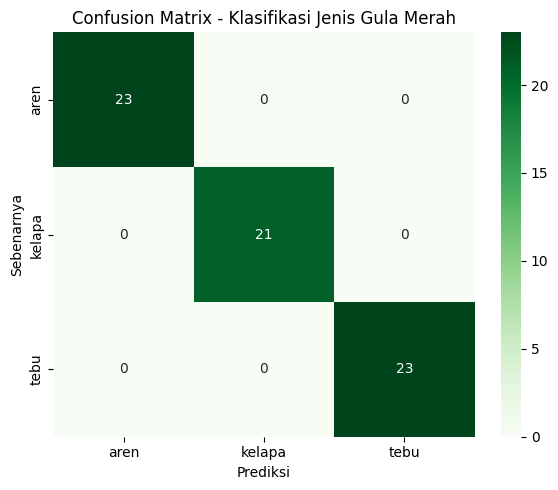

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Prediksi")
plt.ylabel("Sebenarnya")
plt.title("Confusion Matrix - Klasifikasi Jenis Gula Merah")
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE


Feature Importance:
              Feature  Importance
6              mean_V    0.126688
2              skew_H    0.120858
10           edge_std    0.111666
9           edge_mean    0.104651
3              mean_S    0.098303
7               std_V    0.097499
4               std_S    0.093559
5              skew_S    0.069396
8              skew_V    0.042624
1               std_H    0.035791
12  contour_perimeter    0.035615
11       contour_area    0.033824
0              mean_H    0.029526


/tmp/ipython-input-2111931526.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importances, x="Importance", y="Feature", palette="viridis")


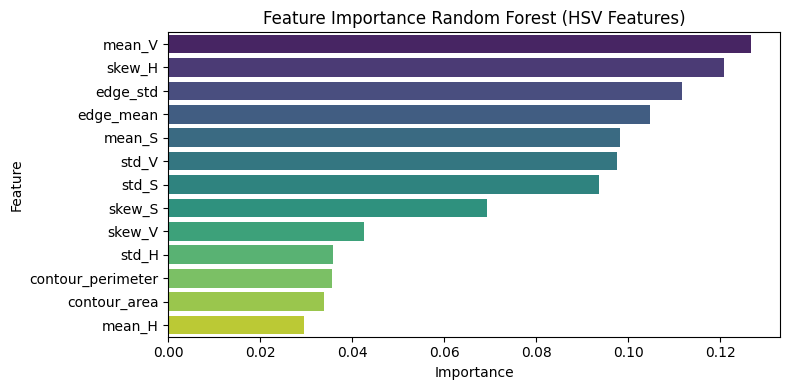

In [ ]:
feat_importances = pd.DataFrame({
    "Feature": df.drop(columns=['label']).columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\nFeature Importance:")
print(feat_importances)

plt.figure(figsize=(8,4))
sns.barplot(data=feat_importances, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance Random Forest (HSV Features)")
plt.tight_layout()
plt.show()

PREDIKSI CITRA BARU


📥 Unggah gambar baru untuk diprediksi:


Saving Gambar WhatsApp 2025-11-20 pukul 06.24.55_3e6684b3.jpg to Gambar WhatsApp 2025-11-20 pukul 06.24.55_3e6684b3.jpg

📸 Gambar diunggah: Gambar WhatsApp 2025-11-20 pukul 06.24.55_3e6684b3.jpg


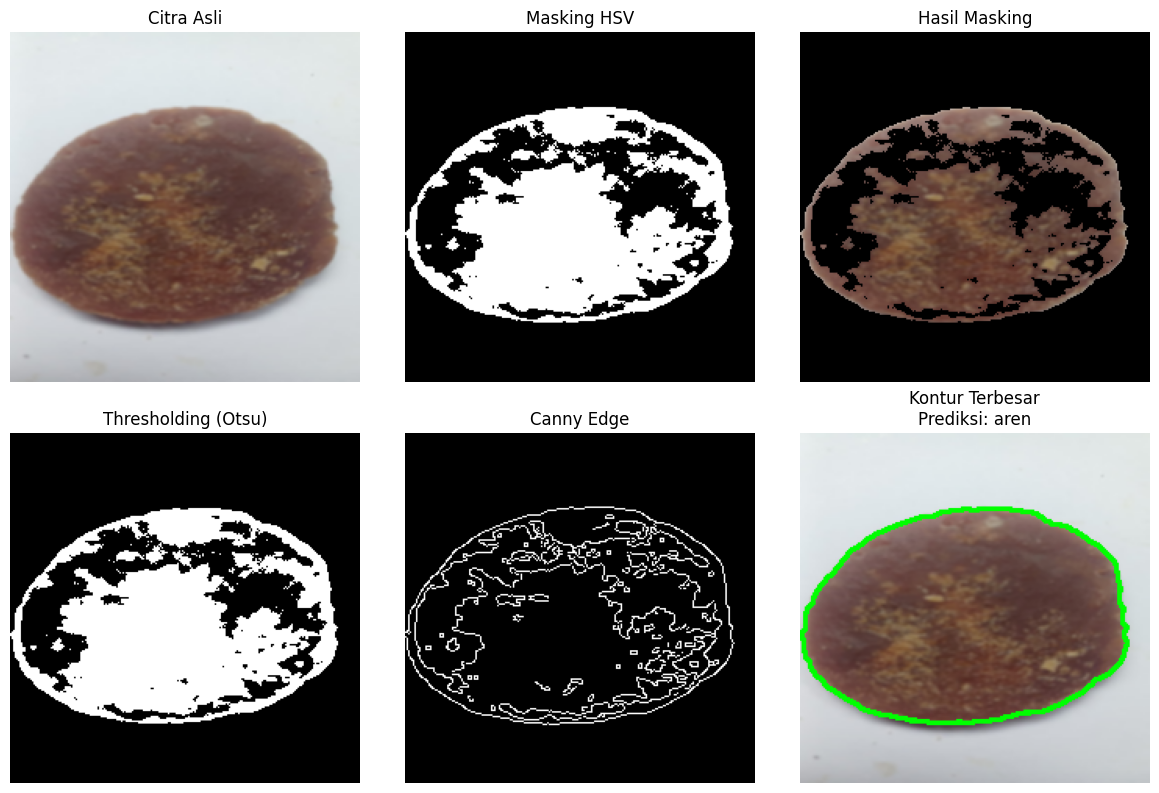


🔮 Prediksi Jenis Gula: aren


'aren'

In [ ]:
def predict_image(path, visualize=True):
    img = read_and_preprocess(path)

    # Ekstraksi fitur
    feats = extract_all_features(img)
    X_new = np.array(list(feats.values())).reshape(1, -1)
    pred = model.predict(X_new)[0]

    # --- VISUALISASI ---
    if visualize:
        mask, masked_img = hsv_mask(img)
        gray = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
        edges, th, contour, area, perimeter = extract_edge_features(gray)

        # Gambar kontur pada citra asli
        img_contour = img.copy()
        if contour is not None:
            cv2.drawContours(img_contour, [contour], -1, (0, 255, 0), 2)

        # Plot semua hasil
        plt.figure(figsize=(12,8))

        plt.subplot(2,3,1)
        plt.imshow(img)
        plt.title("Citra Asli")
        plt.axis("off")

        plt.subplot(2,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Masking HSV")
        plt.axis("off")

        plt.subplot(2,3,3)
        plt.imshow(masked_img)
        plt.title("Hasil Masking")
        plt.axis("off")

        plt.subplot(2,3,4)
        plt.imshow(th, cmap="gray")
        plt.title("Thresholding (Otsu)")
        plt.axis("off")

        plt.subplot(2,3,5)
        plt.imshow(edges, cmap="gray")
        plt.title("Canny Edge")
        plt.axis("off")

        plt.subplot(2,3,6)
        plt.imshow(img_contour)
        plt.title(f"Kontur Terbesar\nPrediksi: {pred}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return pred, feats

def predict_external_image():
    uploaded = files.upload()

    for fname in uploaded.keys():
        print(f"\n📸 Gambar diunggah: {fname}")
        path = fname

        pred, feats = predict_image(path, visualize=True)
        print(f"\n🔮 Prediksi Jenis Gula: {pred}")
        return pred

# Panggil fungsi upload & prediksi
print("\n📥 Unggah gambar baru untuk diprediksi:")
predict_external_image()

